In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter

from IPython.display import display
from IPython.display import clear_output

import seaborn as sns

import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder

# Кластеры для районов
# Таргет трайнуть

In [2]:
DATA_PATH = os.path.join("datasets", "Sber_housing_kaggle")
data_files = ["train.csv", "test.csv"]

In [24]:
def color_cells(val):
    """ val: значение признака """

    if val == 'float64':
        color = 'red'
    elif val == 'int64':
        color = 'red'
    else:
        color = 'blue'
    return f'color: {color}'
info = pd.DataFrame()
info.index = df.columns
info['Тип данных'] = df.dtypes
info['Количесвто уникальных'] = df.nunique()
info['Количество пропусков'] = df.isna().sum()
info['Количество значений'] = df.count()
info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)
info = info.style.applymap(color_cells, subset=['Тип данных'])
info

C:\Users\Nick\AppData\Local\Temp\ipykernel_5108\1141181595.py:18: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


In [6]:
load_data = lambda path, files_names: (
    [pd.read_csv(os.path.join(path, file)) for file in files_names]
)

In [37]:
[Data_train, Data_test] = load_data(DATA_PATH, data_files)
df = Data_train

In [8]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

In [45]:
boolean_columns = [
    'culture_objects_top_25',
    'thermal_power_plant_raion',
    'incineration_raion',
    'oil_chemistry_raion',
    'radiation_raion',
    'railroad_terminal_raion',
    'big_market_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
    'water_1line',
    'big_road1_1line',
    'railroad_1line',
]
binary_category_columns = [
    'product_type',
]
multi_category_columns = [
    'sub_area',
    'ecology',
]
date_сolumns = [
    'timestamp',
]
sub_area_column = [
    'sub_area'
]
ecology_column = [
    'ecology'
]

In [46]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['timestamp'].dt.year
df = df.drop(columns=['timestamp'])

KeyError: 'timestamp'

In [47]:
df['ecology'] = df['ecology'].replace('no data', pd.NA)
print(df['ecology'].unique())

['good' 'excellent' 'poor' 'satisfactory' <NA>]


In [48]:
target_column = 'price_doc'

X = df.drop(columns=[target_column])
y = df[target_column]

In [55]:
ordered_categories = ['poor', 'satisfactory', 'good', 'excellent']

binary_encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
sub_area_encoder = TargetEncoder()
ecology_encoder = OrdinalEncoder(categories=[ordered_categories], handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer([
    ('binary', binary_encoder, binary_category_columns + boolean_columns),
    ('sub_area', sub_area_encoder, sub_area_column),
    ('ecology', ecology_encoder, ecology_column),
], remainder='drop')


pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

encoded_df = pipeline.fit_transform(X, y)

categorical_column_names = binary_category_columns + boolean_columns + sub_area_column + ecology_column

encoded_df = pd.DataFrame(encoded_df, columns=column_names)

In [57]:
X_remaining = X.drop(columns=categorical_column_names)

# Concatenate the encoded columns with the remaining original columns
merged_df = pd.concat([X_remaining.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [53]:
zv = encoded_df

print(zv.columns.tolist())
print(zv['product_type'].unique())
print(zv['sub_area'].unique())
print(zv['ecology'].unique())

['product_type', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'sub_area', 'ecology']
[0. 1.]
[ 6670177.26121295  8392538.85321095  6605065.53020178  8809622.95581738
 11585890.57534375  6047225.85493376 11668452.61086128  7095220.93257751
  9105385.96459264  6403857.43486995  5310922.66585366 14032071.12975969
  7402310.86138596  7435449.50590551  6150727.27473135  9562326.64262193
  5792339.8203405   5198665.77202214  7185202.15989418  7895547.73403932
  7303110.31733718  8690281.89205095  7127992.11048159  6442243.52615541
  6414163.50163964  6335951.33305837  9184445.9767429   8546163.9448393
  7564844.7878366   4850508.2342659   6278500.33670112  5840068.18446257
  5804444.57824297 10048985.25225874  6457895.96774971  8995446.00068613
  6732381.21731199  55849

In [58]:
X = merged_df

In [59]:
model = LinearRegression()

# Forward Selection
sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select=5)
sfs.fit(X, y)

# Получаем выбранные признаки
selected_features = sfs.get_support(indices=True)
print("Выбранные признаки (Forward):", selected_features)

ValueError: Input X contains NaN.
SequentialFeatureSelector does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [7]:
len(X_train)

30471

In [8]:
X_train.head()

id   timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1  2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2  2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3  2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4  2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5  2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq  ...  cafe_count_5000_price_2500  \
0       NaN       NaN  ...                           9   
1       NaN       NaN  ...                          15   
2       NaN       NaN  ...                          10   
3       NaN       NaN  ...                          11   
4       NaN       NaN  ...                         319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1                          3                          0   
2                          3                          0   
3                          2                          1   
4                        108                         17   

   big_church_count_5000  church_count_5000  mosque_count_5000  \
0                     13                 22                  1   
1                     15                 29                  1   
2                     11                 27                  0   
3                      4                  4                  0   
4                    135                236                  2   

   leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                   0                52                  4    5850000  
1                  10                66                 14    6000000  
2                   4                67                 10    5700000  
3                   0                26                  3   13100000  
4                  91               195                 14   16331452  

[5 rows x 292 columns]

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [10]:
X_train["price_doc"].max()

111111112

In [11]:
X_train["price_doc"].value_counts()

price_doc
2000000    757
1000000    747
6000000    372
3000000    332
6500000    330
          ... 
4036219      1
6024000      1
5766464      1
6686450      1
6970959      1
Name: count, Length: 9296, dtype: int64

In [12]:
X_train.describe()

id       full_sq       life_sq         floor     max_floor  \
count  30471.000000  30471.000000  24088.000000  30304.000000  20899.000000   
mean   15237.917397     54.214269     34.403271      7.670803     12.558974   
std     8796.501536     38.031487     52.285733      5.319989      6.756550   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%     7620.500000     38.000000     20.000000      3.000000      9.000000   
50%    15238.000000     49.000000     30.000000      6.500000     12.000000   
75%    22855.500000     63.000000     43.000000     11.000000     17.000000   
max    30473.000000   5326.000000   7478.000000     77.000000    117.000000   

           material    build_year      num_room      kitch_sq         state  \
count  20899.000000  1.686600e+04  20899.000000  20899.000000  16912.000000   
mean       1.827121  3.068057e+03      1.909804      6.399301      2.107025   
std        1.481154  1.543878e+05      0.851805     28.265979      0.880148   
min        1.000000  0.000000e+00      0.000000      0.000000      1.000000   
25%        1.000000  1.967000e+03      1.000000      1.000000      1.000000   
50%        1.000000  1.979000e+03      2.000000      6.000000      2.000000   
75%        2.000000  2.005000e+03      2.000000      9.000000      3.000000   
max        6.000000  2.005201e+07     19.000000   2014.000000     33.000000   

       ...  cafe_count_5000_price_2500  cafe_count_5000_price_4000  \
count  ...                30471.000000                30471.000000   
mean   ...                   32.058318                   10.783860   
std    ...                   73.465611                   28.385679   
min    ...                    0.000000                    0.000000   
25%    ...                    2.000000                    1.000000   
50%    ...                    8.000000                    2.000000   
75%    ...                   21.000000                    5.000000   
max    ...                  377.000000                  147.000000   

       cafe_count_5000_price_high  big_church_count_5000  church_count_5000  \
count                30471.000000           30471.000000       30471.000000   
mean                     1.771783              15.045552          30.251518   
std                      5.418807              29.118668          47.347938   
min                      0.000000               0.000000           0.000000   
25%                      0.000000               2.000000           9.000000   
50%                      0.000000               7.000000          16.000000   
75%                      1.000000              12.000000          28.000000   
max                     30.000000             151.000000         250.000000   

       mosque_count_5000  leisure_count_5000  sport_count_5000  \
count       30471.000000        30471.000000      30471.000000   
mean            0.442421            8.648814         52.796593   
std             0.609269           20.580741         46.292660   
min             0.000000            0.000000          0.000000   
25%             0.000000            0.000000         11.000000   
50%             0.000000            2.000000         48.000000   
75%             1.000000            7.000000         76.000000   
max             2.000000          106.000000        218.000000   

       market_count_5000     price_doc  
count       30471.000000  3.047100e+04  
mean            5.987070  7.123035e+06  
std             4.889219  4.780111e+06  
min             0.000000  1.000000e+05  
25%             1.000000  4.740002e+06  
50%             5.000000  6.274411e+06  
75%            10.000000  8.300000e+06  
max            21.000000  1.111111e+08  

[8 rows x 276 columns]

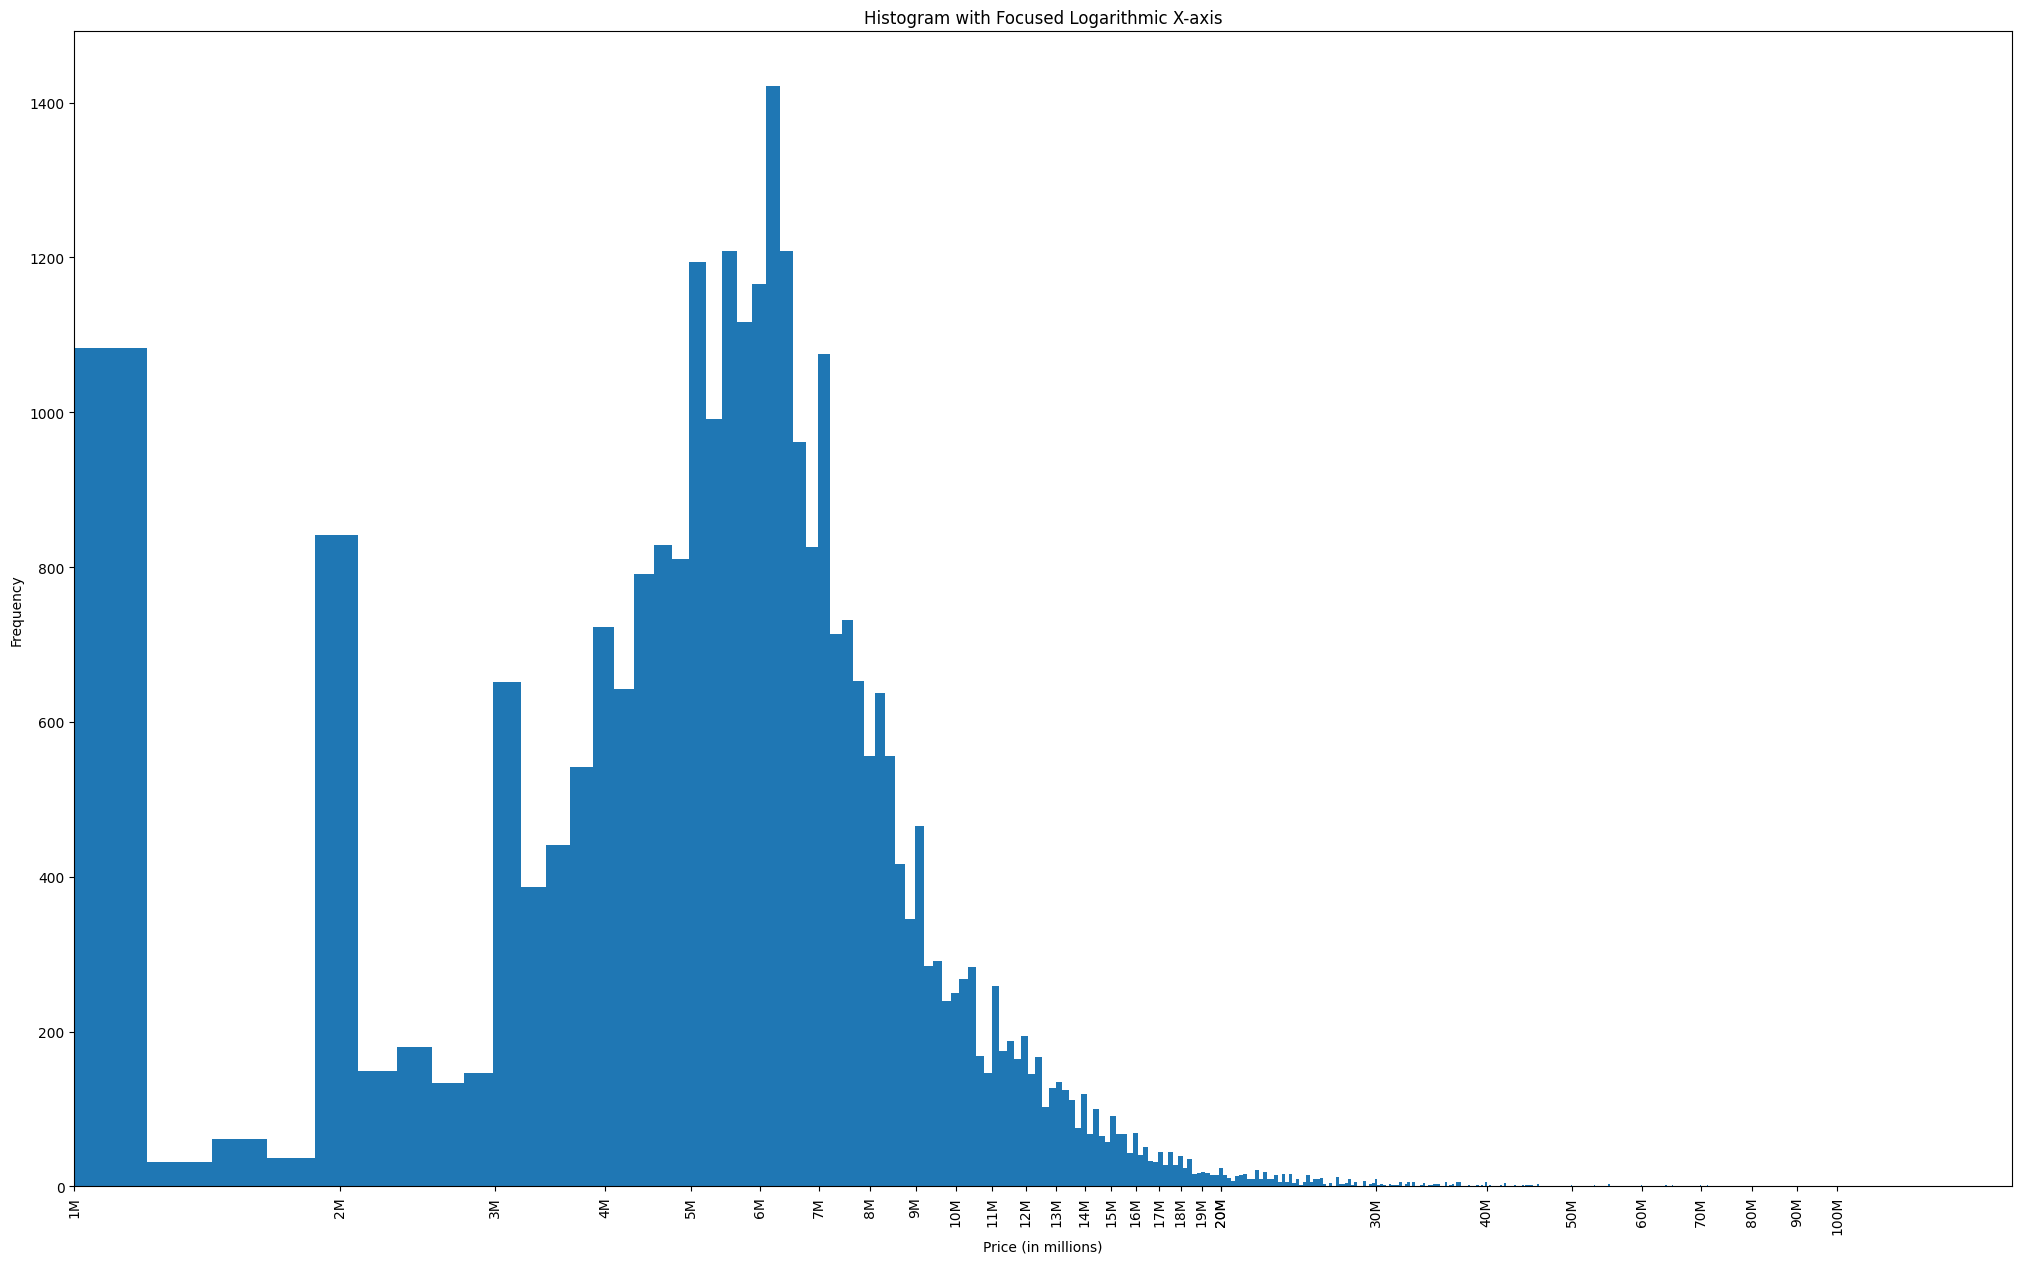

In [13]:
# Create the histogram
plt.figure(figsize=(25, 15))  # Adjust the size as needed
plt.hist(X_train["price_doc"], bins=500)

# Get the current axes object
ax = plt.gca()

# Use a logarithmic scale for the x-axis
ax.set_xscale('log')

# Define specific tick positions for custom intervals
# Ticks from 1M to 20M with steps of 1M, and from 20M to 100M with steps of 10M
ticks = np.concatenate([np.arange(1e6, 2.1e7, 1e6), np.arange(2e7, 1.1e8, 1e7)])

# Apply the tick positions to the x-axis
ax.set_xticks(ticks)

# Define a custom formatter to display x-axis labels in millions
ax.set_xticklabels([f'{int(tick / 1_000_000)}M' for tick in ticks])

# Rotate x-axis labels to 90 degrees for better readability
plt.xticks(rotation=90)

# Set the x-axis limits to start at 1 million
ax.set_xlim(left=1e6)

# Set labels and title
plt.xlabel('Price (in millions)')
plt.ylabel('Frequency')
plt.title('Histogram with Focused Logarithmic X-axis')

# Display the plot
plt.show()


In [14]:
corr_matrix = X_train.select_dtypes(include=[np.number]).corr()

In [15]:
corr_matrix

id   full_sq   life_sq     floor  max_floor  \
id                  1.000000  0.021447  0.014478 -0.022523   0.007037   
full_sq             0.021447  1.000000  0.161112  0.089649   0.119225   
life_sq             0.014478  0.161112  1.000000  0.045090   0.042442   
floor              -0.022523  0.089649  0.045090  1.000000   0.454488   
max_floor           0.007037  0.119225  0.042442  0.454488   1.000000   
...                      ...       ...       ...       ...        ...   
mosque_count_5000  -0.048797  0.021568  0.009945 -0.012256  -0.058255   
leisure_count_5000  0.020671  0.030218  0.022737 -0.044236  -0.048664   
sport_count_5000   -0.011680  0.001580 -0.014499 -0.102101  -0.099855   
market_count_5000  -0.025627 -0.041254 -0.050337 -0.123843  -0.113341   
price_doc           0.121203  0.341840  0.165606  0.117447   0.094386   

                    material  build_year  num_room  kitch_sq     state  ...  \
id                  0.008507   -0.012726  0.014387 -0.010414 -0.119621  ...   
full_sq             0.032866   -0.006041  0.695444  0.020026 -0.091348  ...   
life_sq             0.011393   -0.002401  0.191024  0.000633 -0.066633  ...   
floor              -0.009043    0.001192 -0.005657 -0.008457 -0.113906  ...   
max_floor           0.045915   -0.000261 -0.014220  0.020345 -0.072161  ...   
...                      ...         ...       ...       ...       ...  ...   
mosque_count_5000   0.050355    0.019631  0.062785  0.013183  0.091894  ...   
leisure_count_5000  0.044502   -0.000830  0.058663 -0.006259 -0.003876  ...   
sport_count_5000    0.098482    0.005978  0.089908  0.016866  0.194379  ...   
market_count_5000   0.076378    0.007362  0.061674  0.026404  0.273385  ...   
price_doc           0.064047    0.002161  0.476337  0.028718  0.121303  ...   

                    cafe_count_5000_price_2500  cafe_count_5000_price_4000  \
id                                    0.018635                    0.022958   
full_sq                               0.039083                    0.040059   
life_sq                               0.028735                    0.031551   
floor                                -0.034791                   -0.029636   
max_floor                            -0.040235                   -0.033662   
...                                        ...                         ...   
mosque_count_5000                     0.529434                    0.492859   
leisure_count_5000                    0.986206                    0.975462   
sport_count_5000                      0.824139                    0.778770   
market_count_5000                     0.432265                    0.380154   
price_doc                             0.225566                    0.210354   

                    cafe_count_5000_price_high  big_church_count_5000  \
id                                    0.023704               0.012813   
full_sq                               0.043560               0.026895   
life_sq                               0.034888               0.017845   
floor                                -0.022303              -0.044398   
max_floor                            -0.029525              -0.048235   
...                                        ...                    ...   
mosque_count_5000                     0.481481               0.502028   
leisure_count_5000                    0.948391               0.969029   
sport_count_5000                      0.753384               0.825883   
market_count_5000                     0.353270               0.482547   
price_doc                             0.214327               0.198827   

                    church_count_5000  mosque_count_5000  leisure_count_5000  \
id                           0.015181          -0.048797            0.020671   
full_sq                      0.028579           0.021568            0.030218   
life_sq                      0.018114           0.009945            0.022737   
floor                       -0.045614          -0.012256          

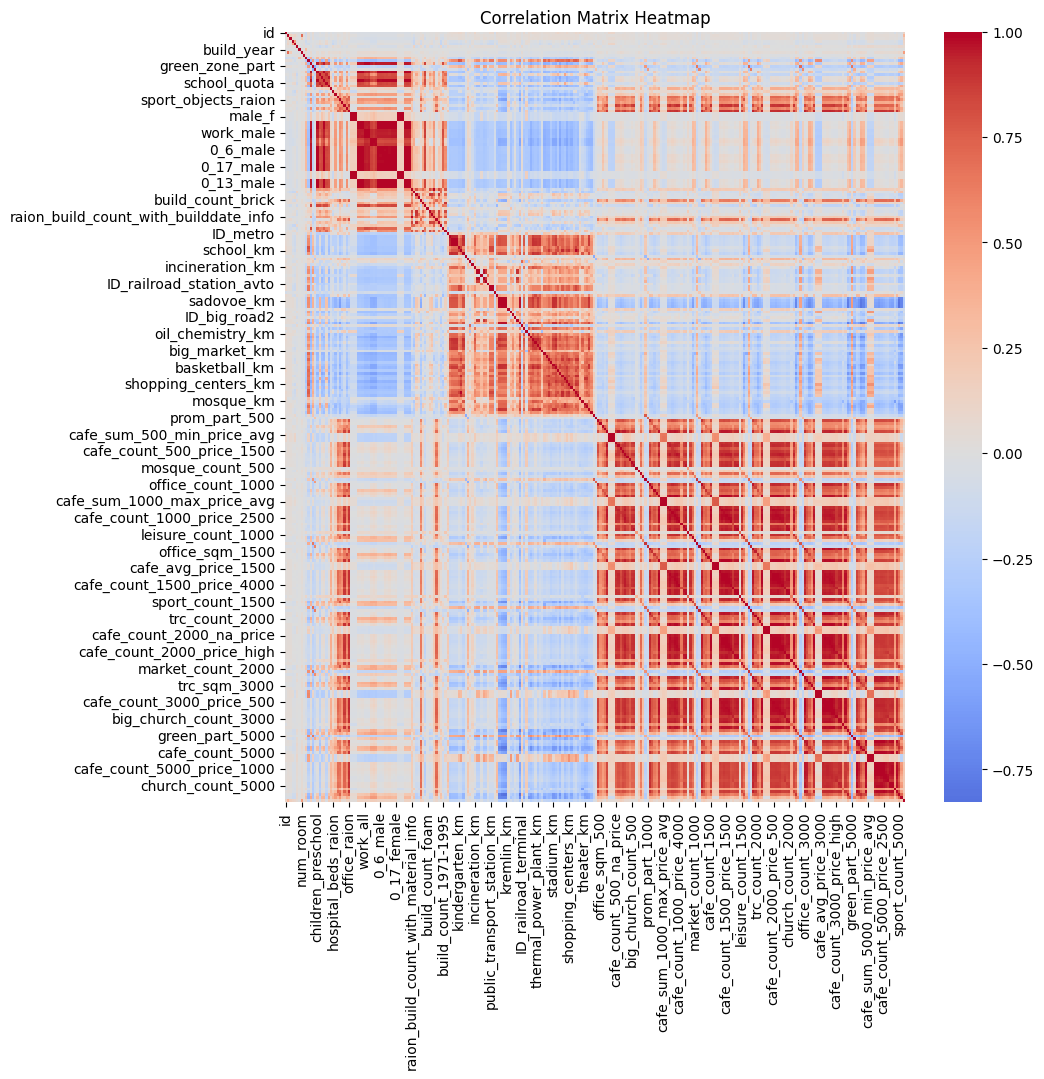

In [16]:
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(corr_matrix)


id   full_sq   life_sq     floor  \
id                                     1.000000  0.021447  0.014478 -0.022523   
full_sq                                0.021447  1.000000  0.161112  0.089649   
life_sq                                0.014478  0.161112  1.000000  0.045090   
floor                                 -0.022523  0.089649  0.045090  1.000000   
max_floor                              0.007037  0.119225  0.042442  0.454488   
material                               0.008507  0.032866  0.011393 -0.009043   
build_year                            -0.012726 -0.006041 -0.002401  0.001192   
num_room                               0.014387  0.695444  0.191024 -0.005657   
kitch_sq                              -0.010414  0.020026  0.000633 -0.008457   
state                                 -0.119621 -0.091348 -0.066633 -0.113906   
area_m                                 0.063572  0.056303  0.061395 -0.019448   
raion_popul                           -0.036259 -0.038929 -0.063985 -0.046933   
green_zone_part                        0.065143  0.030836  0.037145  0.001063   
indust_part                           -0.029797 -0.053589 -0.038889 -0.017861   
children_preschool                    -0.033141 -0.025619 -0.053072 -0.012001   
preschool_quota                        0.004265 -0.003569 -0.037872  0.055406   
preschool_education_centers_raion     -0.048789 -0.010669 -0.050260  0.013214   
children_school                       -0.031463 -0.024265 -0.051592 -0.016466   
school_quota                           0.006000  0.016256  0.001007  0.080233   
school_education_centers_raion        -0.042350 -0.012084 -0.050132 -0.006784   
school_education_centers_top_20_raion  0.006982  0.020713  0.005126 -0.009889   
hospital_beds_raion                   -0.029219 -0.001604  0.002740 -0.101810   
healthcare_centers_raion              -0.008652 -0.007840 -0.028375 -0.076722   
university_top_20_raion                0.010600  0.045654  0.024891  0.001380   
sport_objects_raion                    0.000337  0.028109 -0.001790 -0.035833   
additional_education_raion            -0.008573  0.007401 -0.003371  0.044471   
culture_objects_top_25_raion           0.041442  0.026174  0.033817  0.014816   
shopping_centers_raion                 0.009468  0.010188 -0.004090  0.016040   
office_raion                           0.029074  0.033494  0.032057 -0.019585   
full_all                              -0.017025  0.012936 -0.022720 -0.028050   
male_f                                -0.017087  0.012862 -0.022640 -0.028476   
female_f                              -0.016967  0.012995 -0.022779 -0.027682   
young_all                             -0.032380 -0.025232 -0.052594 -0.014832   
young_male                            -0.032936 -0.024877 -0.052366 -0.014394   
young_female                          -0.031724 -0.025560 -0.052706 -0.015272   
work_all                              -0.035836 -0.038306 -0.063767 -0.039906   
work_male                             -0.035796 -0.037868 -0.063720 -0.039843   
work_female                           -0.035687 -0.038548 -0.063360 -0.039759   
ekder_all                             -0.036944 -0.046142 -0.065203 -0.083285   
ekder_male                            -0.036922 -0.042117 -0.060862 -0.080779   
ekder_female                          -0.036778 -0.047715 -0.066721 -0.084005   
0_6_all                               -0.033141 -0.025619 -0.053072 -0.012001   
0_6_male                              -0.033320 -0.025497 -0.052864 -0.012182   
0_6_female                            -0.032881 -0.025704 -0.053175 -0.011773   
7_14_all                              -0.031463 -0.024265 -0.051592 -0.016466   
7_14_male                             -0.032444 -0.023616 -0.051300 -0.015188   
7_14_female                           -0.030323 -0.024872 -0.051687 -0.017762   
0_17_all                              -0.032618 -0.025166 -0.052790 -0.016481   
0_17_male                             -0.033072 -0.024702 -0.052545 -0.01587

In [18]:
pd.set_option('display.max_info_columns', 300)
non_numeric_cols = X_train.select_dtypes(exclude=[np.number])
non_numeric_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   timestamp                  30471 non-null  object
 1   product_type               30471 non-null  object
 2   sub_area                   30471 non-null  object
 3   culture_objects_top_25     30471 non-null  object
 4   thermal_power_plant_raion  30471 non-null  object
 5   incineration_raion         30471 non-null  object
 6   oil_chemistry_raion        30471 non-null  object
 7   radiation_raion            30471 non-null  object
 8   railroad_terminal_raion    30471 non-null  object
 9   big_market_raion           30471 non-null  object
 10  nuclear_reactor_raion      30471 non-null  object
 11  detention_facility_raion   30471 non-null  object
 12  water_1line                30471 non-null  object
 13  big_road1_1line            30471 non-null  object
 14  railro

In [38]:
encoded_df, encoded_columns = encodeBool(X_train, [['yes', 'no']])

In [39]:
encoded_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   culture_objects_top_25     30471 non-null  float64
 1   thermal_power_plant_raion  30471 non-null  float64
 2   incineration_raion         30471 non-null  float64
 3   oil_chemistry_raion        30471 non-null  float64
 4   radiation_raion            30471 non-null  float64
 5   railroad_terminal_raion    30471 non-null  float64
 6   big_market_raion           30471 non-null  float64
 7   nuclear_reactor_raion      30471 non-null  float64
 8   detention_facility_raion   30471 non-null  float64
 9   water_1line                30471 non-null  float64
 10  big_road1_1line            30471 non-null  float64
 11  railroad_1line             30471 non-null  float64
dtypes: float64(12)
memory usage: 2.8 MB


In [40]:
encoded_df['culture_objects_top_25'].unique()

array([0., 1.])